In [18]:
%matplotlib inline

import imageio
import skimage.io as io
import numpy as np

images_video_filename = 'EndoscopeImageMemory_0.avi'

# Creating readers for each of our videos
images_reader = imageio.get_reader(images_video_filename, 'ffmpeg')

current_dataset_number_of_images = images_reader.get_length()



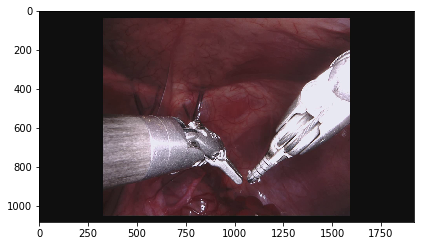

In [21]:
index = 1000

current_image = np.asarray(images_reader.get_data(index))

io.imshow(current_image)

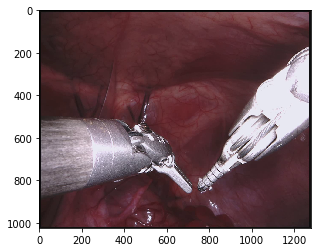

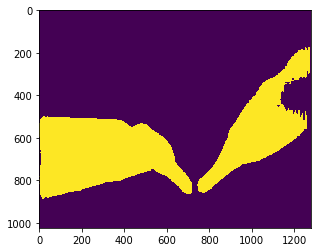

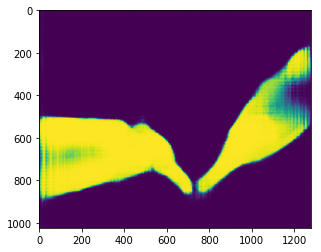

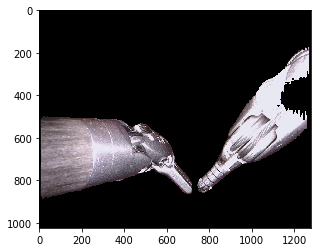

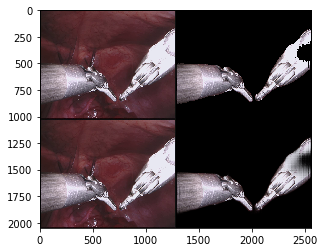

In [59]:
import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '1'


from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

import numpy as np


img_path = '/home/daniil/projects/endovis/dataset/instrument_dataset_2/left_frames/frame003.png'


valid_transform = transforms.Compose(
                [
                     transforms.CenterCrop((1024, 1280)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ])

just_crop_transform = transforms.CenterCrop((1024, 1280))

fcn = resnet_dilated.Resnet18_8s(num_classes=2)
fcn.load_state_dict(torch.load('resnet_18_8s_best.pth'))
fcn.cuda()
fcn.eval()


img_not_preprocessed = Image.fromarray(current_image).convert('RGB')#.resize((512, 512))

current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

img = valid_transform(img_not_preprocessed)

img = img.unsqueeze(0)

img = Variable(img.cuda())

res = fcn(img)

soft_labels = torch.nn.functional.softmax(res).squeeze(0)

_, hard_labels = res.squeeze(0).max(0)

segmentation = hard_labels.data.cpu().numpy().squeeze()
soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

double_view = np.zeros((1024*2, 1280*2, 3), np.uint8)

double_view[:1024, :1280, :] = current_img_crop
double_view[:1024, 1280:, :] = hard_masked_out_instrument

double_view[1024:, :1280] = current_img_crop
double_view[1024:, 1280:] = soft_masked_out_instrument

plt.imshow(current_img_crop)
plt.show()

plt.imshow(segmentation)
plt.show()

plt.imshow(soft_mask)
plt.show()

plt.imshow(hard_masked_out_instrument)
plt.show()

plt.imshow(double_view)
plt.show()

In [63]:
save_file_template = 'output_frames/{0:08d}.png'

for index in xrange(10):

    current_image = np.asarray(images_reader.get_data(index))
    
    img_not_preprocessed = Image.fromarray(current_image).convert('RGB')#.resize((512, 512))

    current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

    img = valid_transform(img_not_preprocessed)

    img = img.unsqueeze(0)

    img = Variable(img.cuda())

    res = fcn(img)

    soft_labels = torch.nn.functional.softmax(res).squeeze(0)

    _, hard_labels = res.squeeze(0).max(0)

    segmentation = hard_labels.data.cpu().numpy().squeeze()
    soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

    hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

    soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

    double_view = np.zeros((1024*2, 1280*2, 3), np.uint8)

    double_view[:1024, :1280, :] = current_img_crop
    double_view[:1024, 1280:, :] = hard_masked_out_instrument

    double_view[1024:, :1280] = current_img_crop
    double_view[1024:, 1280:] = soft_masked_out_instrument
    
    image_filename_to_save = save_file_template.format(index)
    
    plt.imsave(image_filename_to_save, double_view)
    
    print(image_filename_to_save)
    

In [62]:
save_file_template.format(1344)

'output_frames/00001344.png'

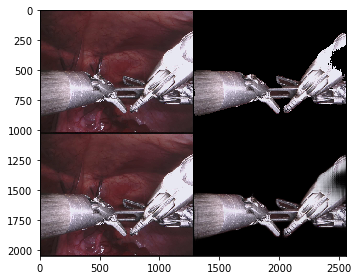

In [65]:
io.imshow('output_frames/00000001.png')